In [1]:
import scipy.io as io
import matplotlib.pyplot as plt
import numpy as np

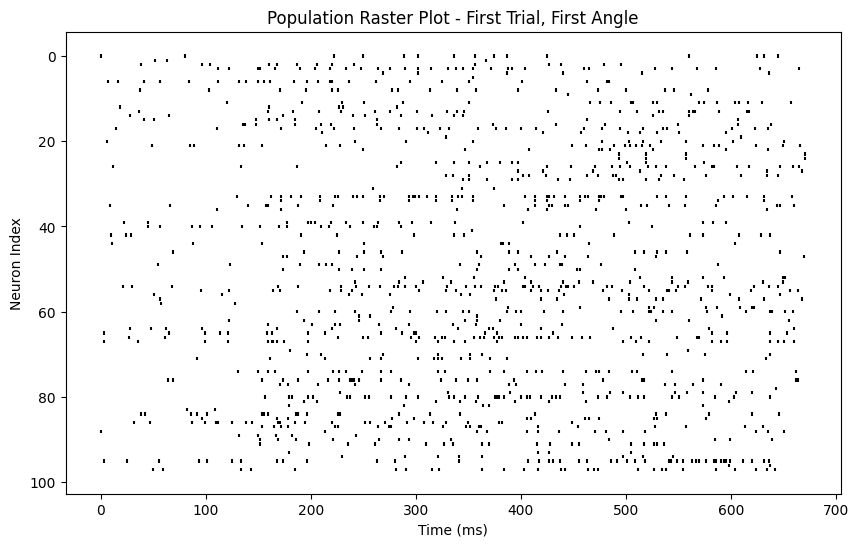

In [5]:
# Load data
data = io.loadmat("monkeydata_training.mat")
trials = data['trial']
# Access the first trial for the first angle
first_trial_first_angle = trials[0, 0]
spikes = first_trial_first_angle['spikes'] # Assuming [neurons, time] structure
hand_pos = first_trial_first_angle['handPos']
positions = [np.where(neuron_spikes == 1)[0] for neuron_spikes in spikes]
# Plotting
plt.figure(figsize=(10, 6))
plt.eventplot(positions, lineoffsets=np.arange(spikes.shape[0]), linelengths=0.75, colors='black')
plt.gca().invert_yaxis()  # Invert y axis so neuron 1 is at the top
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Population Raster Plot - First Trial, First Angle')
plt.show()

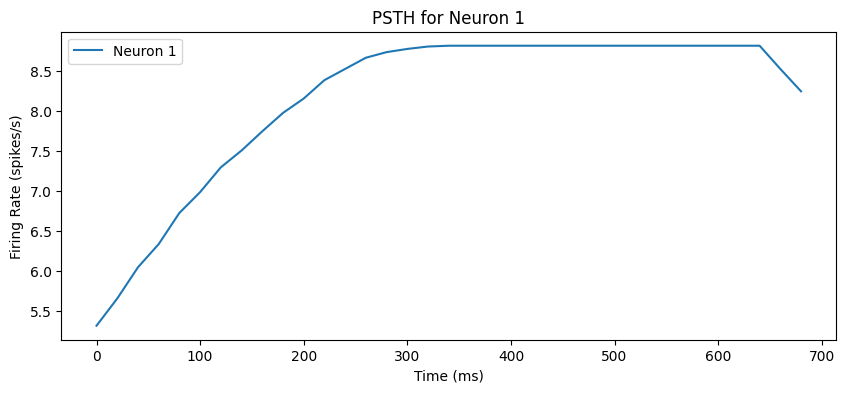

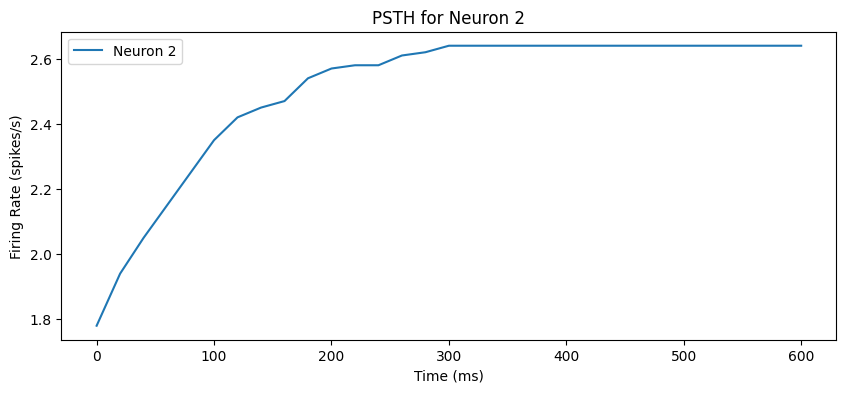

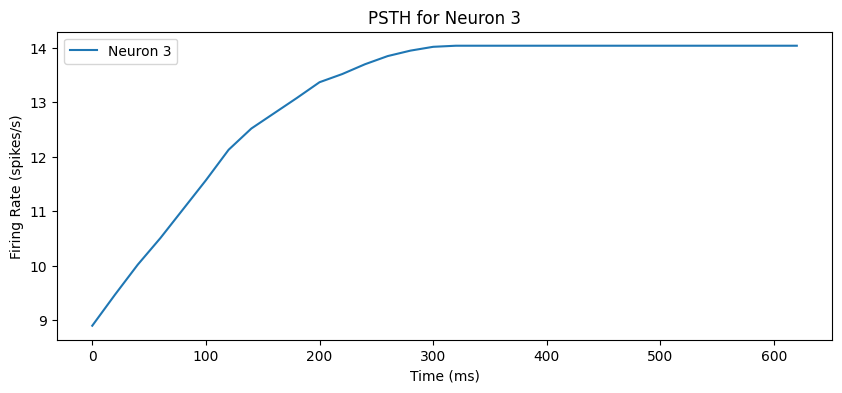

In [13]:
def compute_and_plot_psth_fixed(trials, neuron_idx, bin_size=20, smooth_window=50):
    """
    Compute and plot the Peri-Stimulus Time Histogram (PSTH) for a given neuron
    across all trials for the first angle, with optional smoothing, ensuring the
    dimensionality matches between time bins and smoothed firing rates.

    Parameters:
    - trials: the trials data from the dataset
    - neuron_idx: index of the neuron for which to compute the PSTH
    - bin_size: size of each bin in ms for the PSTH
    - smooth_window: window size for smoothing the PSTH
    """
    spike_times_all_trials = []

    # Collect spike times for the neuron across all trials for the first angle
    for trial in trials[:, 0]:
        spikes = trial['spikes'][neuron_idx, :]
        spike_times = np.where(spikes == 1)[0]
        spike_times_all_trials.extend(spike_times)

    # Compute histogram
    max_time = np.max(spike_times_all_trials)
    bins = np.arange(0, max_time + bin_size, bin_size)
    hist, bin_edges = np.histogram(spike_times_all_trials, bins=bins)

    # Convert to rate
    hist = hist / len(trials) * (1000 / bin_size)  # Normalize by number of trials and convert to Hz

    # Smooth the histogram
    window = np.ones(smooth_window) / smooth_window
    hist_smoothed = np.convolve(hist, window, mode='same')
    
    # Correct for the convolution effect on the dimensionality
    hist_smoothed = hist_smoothed[:len(bin_edges)-1]  # Adjust to match the length of bin_edges

    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(bin_edges[:-1], hist_smoothed, label=f'Neuron {neuron_idx + 1}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing Rate (spikes/s)')
    plt.title(f'PSTH for Neuron {neuron_idx + 1}')
    plt.legend()

# Re-plotting PSTHs for the first 3 neurons with the fixed function
for neuron_idx in range(3):
    compute_and_plot_psth_fixed(data['trial'], neuron_idx)

plt.show()

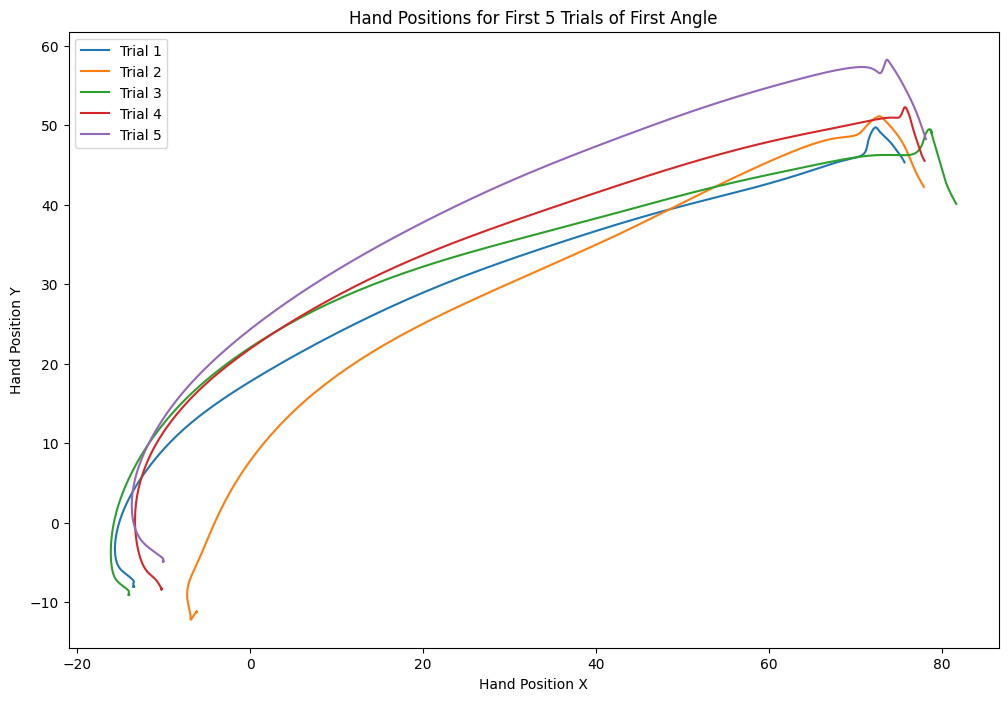

In [10]:
# Plot hand positions for the first 5 trials of the first angle
plt.figure(figsize=(12, 8))

for trial_idx in range(5):
    trial_data = data['trial'][trial_idx, 0]
    hand_pos = trial_data['handPos'][:2, :]  # Extracting x and y positions, ignoring z if present

    # Plotting x vs y hand positions
    plt.plot(hand_pos[0, :], hand_pos[1, :], label=f'Trial {trial_idx + 1}')

plt.xlabel('Hand Position X')
plt.ylabel('Hand Position Y')
plt.title('Hand Positions for First 5 Trials of First Angle')
plt.legend()
plt.show()

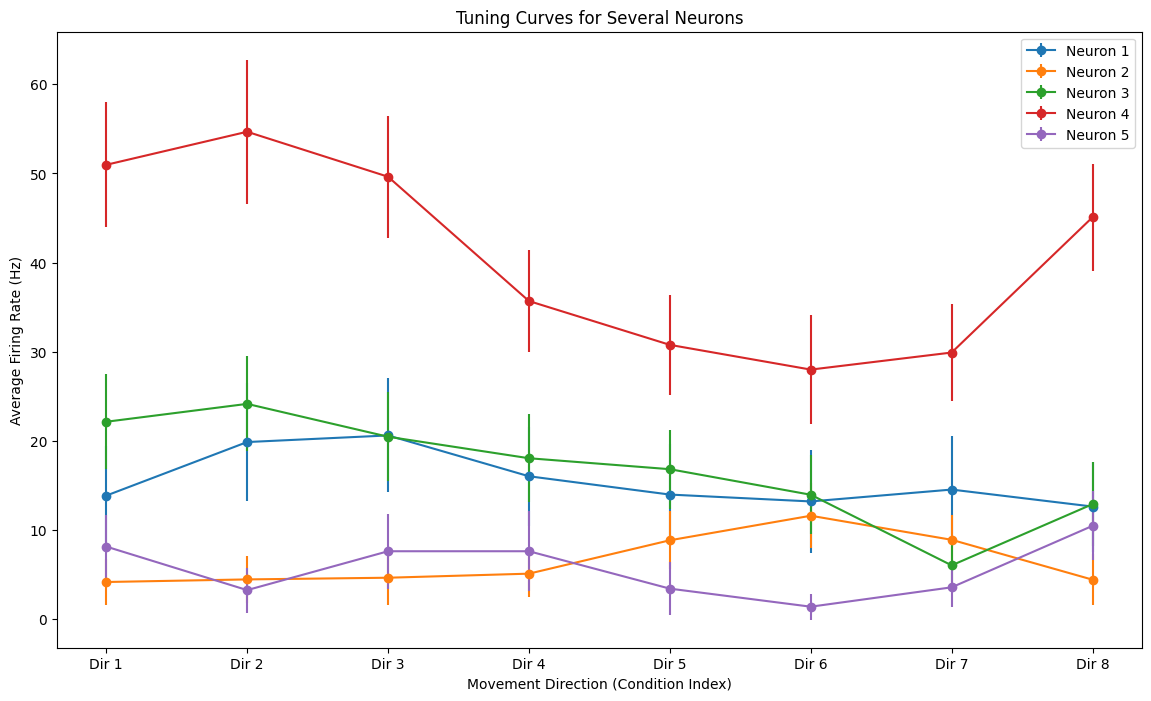

In [15]:
def compute_tuning_curves(trials):
    """
    Compute the tuning curves for all neurons across all movement directions.
    
    Parameters:
    - trials: the trials data from the dataset
    
    Returns:
    - tuning_curves: A dictionary with neuron indices as keys and their tuning curves (average firing rates for each direction) as values.
    - std_devs: A dictionary with neuron indices as keys and the standard deviations of the firing rates for each direction as values.
    """
    num_neurons = trials[0, 0]['spikes'].shape[0]
    num_directions = trials.shape[1]
    
    # Initialize dictionaries to store tuning curve data and standard deviations
    tuning_curves = {neuron: np.zeros(num_directions) for neuron in range(num_neurons)}
    std_devs = {neuron: np.zeros(num_directions) for neuron in range(num_neurons)}
    
    # Loop through each direction and each neuron to compute the tuning curves
    for direction in range(num_directions):
        for neuron in range(num_neurons):
            firing_rates = []
            # Loop through trials to calculate firing rates
            for trial in trials[:, direction]:
                spikes = trial['spikes'][neuron, :]
                firing_rate = np.sum(spikes) / spikes.size * 1000  # Convert to Hz
                firing_rates.append(firing_rate)
            
            # Compute average firing rate and standard deviation for the current direction
            tuning_curves[neuron][direction] = np.mean(firing_rates)
            std_devs[neuron][direction] = np.std(firing_rates)
    
    return tuning_curves, std_devs

# Compute tuning curves and standard deviations
tuning_curves, std_devs = compute_tuning_curves(data['trial'])

# Plot tuning curves for the first few neurons as an example
plt.figure(figsize=(14, 8))
directions = np.arange(8)  # Assuming 8 directions corresponding to the dataset structure

for neuron in range(5):  # Plot for the first 4 neurons as an example
    plt.errorbar(directions, tuning_curves[neuron], yerr=std_devs[neuron], label=f'Neuron {neuron+1}', fmt='-o')

plt.xlabel('Movement Direction (Condition Index)')
plt.ylabel('Average Firing Rate (Hz)')
plt.title('Tuning Curves for Several Neurons')
plt.xticks(directions, labels=[f'Dir {i+1}' for i in directions])
plt.legend()
plt.show()

In [18]:
def compute_population_vector(trials, trial_idx, direction_idx):
    """
    Compute the population vector for a given trial and direction.
    
    Parameters:
    - trials: the trials data from the dataset
    - trial_idx: index of the trial to analyze
    - direction_idx: index of the movement direction
    
    Returns:
    - population_vector: The computed population vector for the trial
    """
    trial_data = trials[trial_idx, direction_idx]
    num_neurons = trial_data['spikes'].shape[0]
    
    # Assuming each direction is equally spaced and represented by an angle in radians
    directions_radians = np.linspace(0, 2 * np.pi, 8, endpoint=False)
    
    # Initialize the population vector
    population_vector = np.zeros(2)  # For x and y components
    
    # Loop through each neuron to contribute to the population vector
    for neuron in range(num_neurons):
        firing_rate = np.sum(trial_data['spikes'][neuron, :]) / trial_data['spikes'].shape[1] * 1000  # Convert to Hz
        preferred_direction = directions_radians[np.argmax(tuning_curves[neuron])]  # Based on max firing rate
        
        # Compute the contribution vector for the neuron
        neuron_vector = np.array([np.cos(preferred_direction), np.sin(preferred_direction)]) * firing_rate
        
        # Add the neuron's vector to the population vector
        population_vector += neuron_vector
    
    return population_vector

# Compute the population vector for the first trial of the first angle
population_vector = compute_population_vector(data['trial'], 0, 0)

# Display the computed population vector
population_vector.round(2)


array([ 215.  , -617.35])